In [47]:
from itertools import permutations, product

import functools

import tqdm

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

import numpy as np
from numpy import mean,std

import pickle

from os import path

import matplotlib.pyplot as plt

from warnings import simplefilter
from collections import OrderedDict

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)



In [48]:
df = pd.read_csv('info.csv')
# print(df.loc[:, df.columns != 'isZoonotic'])
# print(df)
# print(len(df.columns))

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'isZoonotic'], df['isZoonotic'], test_size=0.2, random_state=1)
for col in df.columns:
    col != 'isZoonotic' and X_train[col].isnull().sum() != 0 and print(X_train[col].isnull().sum())


In [49]:
lrmodel = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
lrmodel.fit(X_train, y_train)

LogisticRegression(fit_intercept=False, max_iter=1000,
                   multi_class='multinomial', random_state=42, solver='saga',
                   tol=0.001)

In [50]:
# all 0s for some reason
print(X_test[:10])
predictions = lrmodel.predict(X_test)
print(accuracy_score(y_test, predictions))

          tggc      ttcc      tatg      gtat      aatg      acag      atgg  \
1302  0.225806  0.451613  0.483871  0.354839  0.612903  0.322581  0.258065   
6596  0.096491  0.622807  0.324561  0.377193  0.500000  0.201754  0.219298   
4095  0.387097  0.419355  0.677419  0.290323  0.451613  0.193548  0.290323   
7284  0.238784  0.347956  0.250249  0.255733  0.409771  0.216351  0.284646   
4899  0.294574  0.426357  0.620155  0.387597  0.565891  0.178295  0.426357   
6289  0.276923  0.353846  0.392308  0.192308  0.538462  0.346154  0.469231   
7830  0.328801  0.144623  0.023486  0.040791  0.045735  0.133498  0.173053   
2048  0.397284  0.325976  0.040747  0.105263  0.027165  0.154499  0.166384   
7122  0.177982  0.236697  0.352294  0.403670  0.585321  0.258716  0.313761   
7488  0.684211  0.263158  0.421053  0.263158  0.473684  0.105263  0.210526   

          tact      tcaa      aggc  ...      ggca      gacc      agct  \
1302  0.516129  0.354839  0.161290  ...  0.161290  0.161290  0.22580

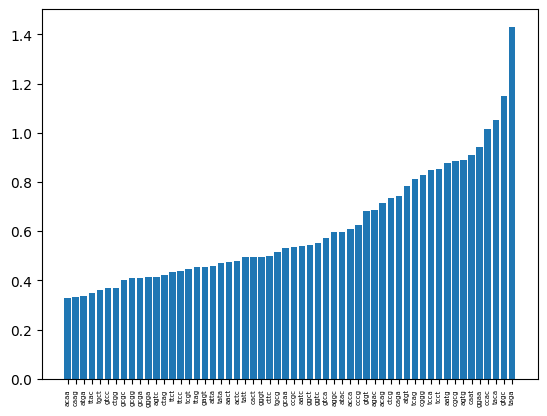

In [52]:
results = lrmodel.coef_[0]

l = zip([x for x in X_test.columns.values],results)
l = list(l)
res = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=5)

plt.bar([x[0] for x in res[200:]], [x[1] for x in res[200:]])
plt.show()

In [39]:
def getRealLength(kmer):
    print(X_test.iloc[0])
    
    sums = [kmer-1+((X_test.iloc[x].sum())/kmer) for x in range(len(X_test))]
    print(sums)

In [78]:
knntest = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors = 1, n_jobs = 1), n_estimators = 10, n_jobs = 1)

knntest.fit(X_train, y_train)
# knn = KNeighborsClassifier(n_neighbors=5)

BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=1,
                                                              n_neighbors=1),
                          n_jobs=1)

In [54]:
predictions = knntest.predict(X_test)
print(predictions[:10])
print(accuracy_score(y_test, predictions))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0.9045599151643691


In [55]:
randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"))

randforest.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt'))

In [56]:
def saveModel(model, name, X_test, y_test, params=None, dir='curr_models', gradBoost=False, xgBoost=False):
    
    
    if not path.exists(f"{dir}/{name}.pkl"):
        print("does not exist")

        pickle.dump(model, open(f'{dir}/{name}.pkl', 'wb'))
    else:
        predictions = model.predict(X_test)
        currAcc = accuracy_score(y_test, predictions)

        pickled_model = pickle.load(open(f'{dir}/{name}.pkl', 'rb'))
        
        if gradBoost:
            # get features here 
            cols_when_model_builds = pickled_model.feature_names_in_
            X_test=X_test[cols_when_model_builds]
        elif xgBoost:
            # put features into the same order that the model was trained in
            cols_when_model_builds = pickled_model.get_booster().feature_names
            X_test=X_test[cols_when_model_builds]
        
        # .values?
        
        picklePredictions=pickled_model.predict(X_test)
        pickleAcc=accuracy_score(y_test, picklePredictions)
        
        if currAcc > pickleAcc:
            print("update!")
            print(confusion_matrix(y_test, picklePredictions))

            print("curr", currAcc, "pickle", pickleAcc)
            pickle.dump(model, open(f'{dir}/{name}.pkl', 'wb'))

            if params != None:
                pickle.dump(params, open(f'{dir}/{name}-params.pkl', 'wb'))
        else:
            print("no update")
            print("curr", currAcc, "pickle", pickleAcc)
            print(confusion_matrix(y_test, picklePredictions))

            model=pickled_model
    return model

In [57]:
saveModel(randforest, "randforest", X_test, y_test)

predictions = randforest.predict(X_test)
print(accuracy_score(y_test, predictions))

# for i in range(1000):
#     predictions[i] != y_test_list[i] and print(predictions[i], "vs", y_test_list[i])

update!
[[1536   98]
 [  43  209]]
curr 0.9347826086956522 pickle 0.925238600212089
0.9347826086956522


In [58]:
probability_predictions = randforest.predict_proba(X_test)
preds = randforest.predict(X_test)
print(accuracy_score(y_test, preds))


0.9347826086956522


In [61]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":120, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "min_sample_split":50,
    "subsample":0.8
    # "warm_start":True
}


# careful with WARM START - only works after a lot of iterations
for learning_rate in lr_list:
    gradBoost = GradientBoostingClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, max_features=parameters['max_features'], 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    min_samples_split=parameters['min_sample_split'], subsample=parameters['subsample']
    )

    parameters['learning_rate']=learning_rate
    gradBoost.fit(X_train, y_train)

    cols_when_model_builds = gradBoost.feature_names_in_
    X_test=X_test[cols_when_model_builds]
    
    testingAcc = accuracy_score(y_test, gradBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, gradBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(gradBoost, "gradBoost", X_test, y_test, parameters, gradBoost=True)

Learning rate:  0.05
Accuracy score (validation): 0.951
no update
curr 0.9506892895015907 pickle 0.95864262990456
[[1610   24]
 [  54  198]]
Learning rate:  0.075
Accuracy score (validation): 0.957
no update
curr 0.957051961823966 pickle 0.95864262990456
[[1610   24]
 [  54  198]]
Learning rate:  0.1
Accuracy score (validation): 0.957
no update
curr 0.957051961823966 pickle 0.95864262990456
[[1610   24]
 [  54  198]]
Learning rate:  0.15
Accuracy score (validation): 0.960
update!
[[1610   24]
 [  54  198]]
curr 0.9597030752916225 pickle 0.95864262990456
Learning rate:  0.2
Accuracy score (validation): 0.958
no update
curr 0.9581124072110286 pickle 0.9597030752916225
[[1619   15]
 [  61  191]]
Learning rate:  0.25
Accuracy score (validation): 0.958
no update
curr 0.9581124072110286 pickle 0.9597030752916225
[[1619   15]
 [  61  191]]
Learning rate:  0.3
Accuracy score (validation): 0.957
no update
curr 0.9565217391304348 pickle 0.9597030752916225
[[1619   15]
 [  61  191]]
Learning rate

In [62]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":100, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "subsample":0.8,
    'lambda': 0.5, # regularization?
    'alpha': 0.5
}



for learning_rate in lr_list:
    xgBoost = XGBClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    subsample=parameters['subsample'], 
    )

    parameters['learning_rate']=learning_rate
    xgBoost.fit(X_train, y_train)

    # ALWAYS reset feature names
    cols_when_model_builds = xgBoost.get_booster().feature_names
    X_test=X_test[cols_when_model_builds]

    testingAcc = accuracy_score(y_test, xgBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, xgBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(xgBoost, "xgBoost", X_test, y_test, parameters, xgBoost=True)

Learning rate:  0.05
Accuracy score (validation): 0.961
no update
curr 0.9612937433722163 pickle 0.9650053022269353
[[1620   14]
 [  52  200]]
Learning rate:  0.075
Accuracy score (validation): 0.962
no update
curr 0.9623541887592789 pickle 0.9650053022269353
[[1620   14]
 [  52  200]]


KeyboardInterrupt: 

In [68]:
# Models within "orig_models" folder have the highest training acc but not as great cross val

best_xgboost = pickle.load(open('curr_models/xgBoost.pkl', 'rb'))
best_xgboost_params = pickle.load(open('curr_models/xgBoost-params.pkl', 'rb'))

best_gradBoost = pickle.load(open('curr_models/gradBoost.pkl', 'rb'))
best_gradBoost_params = pickle.load(open('curr_models/gradBoost-params.pkl', 'rb'))

best_rF = pickle.load(open('curr_models/randforest.pkl', 'rb'))

print(best_xgboost_params)
print(best_gradBoost_params)

cols_when_model_builds = best_xgboost.get_booster().feature_names
X_test=X_test[cols_when_model_builds]

print("Best XG Accuracy: ", accuracy_score(y_test, best_xgboost.predict(X_test)))
print("Balanced XG Accuracy: ", balanced_accuracy_score(y_test, best_xgboost.predict(X_test)))
print(confusion_matrix(y_test, best_gradBoost.predict(X_test)))


cols_when_model_builds = best_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

print("Best GB Accuracy: ", accuracy_score(y_test, best_gradBoost.predict(X_test)))
print("Balanced GB Accuracy: ", balanced_accuracy_score(y_test, best_gradBoost.predict(X_test)))
print(confusion_matrix(y_test, best_gradBoost.predict(X_test)))

print("Best rF Accuracy: ", accuracy_score(y_test, best_rF.predict(X_test)))
print("Balanced rF Accuracy: ", balanced_accuracy_score(y_test, best_rF.predict(X_test)))
print(confusion_matrix(y_test, best_rF.predict(X_test)))


print("Best lR Accuracy: ", accuracy_score(y_test, lrmodel.predict(X_test)))
print("Balanced lR Accuracy: ", balanced_accuracy_score(y_test, lrmodel.predict(X_test)))
print(confusion_matrix(y_test, lrmodel.predict(X_test)))


{'n_estimators': 100, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'subsample': 0.8, 'lambda': 0.5, 'alpha': 0.5, 'learning_rate': 0.25}
{'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.15}
Best XG Accuracy:  0.9650053022269353
Balanced XG Accuracy:  0.8925414310971227
[[1619   15]
 [  61  191]]
Best GB Accuracy:  0.9597030752916225
Balanced GB Accuracy:  0.8743782906879602
[[1619   15]
 [  61  191]]
Best rF Accuracy:  0.9347826086956522
Balanced rF Accuracy:  0.8918808649530804
[[1553   81]
 [  42  210]]
Best lR Accuracy:  0.9406150583244963
Balanced lR Accuracy:  0.8297997901731071
[[1603   31]
 [  81  171]]


precision recall: 0.9102284209119
[0.00133047 0.00039226 0.00157543 ... 0.0013788  0.05729642 0.00091007]


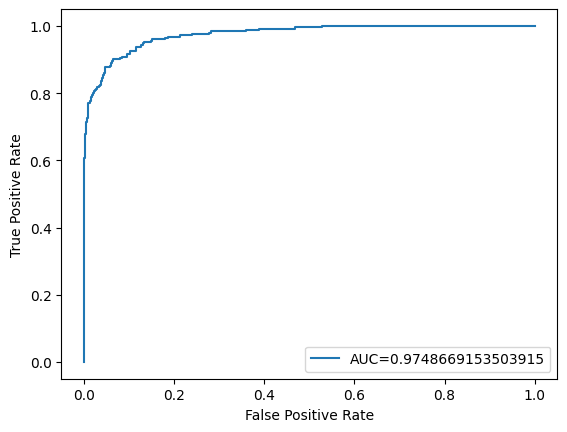

In [69]:
# ALWAYS reset X columns to the right order
cols_when_model_builds = best_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_gradBoost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = best_gradBoost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()


precision recall: 0.9231663914507396
[2.4202900e-04 1.2568987e-04 4.0366469e-04 ... 2.4270930e-04 1.2962392e-02
 1.3155343e-05]


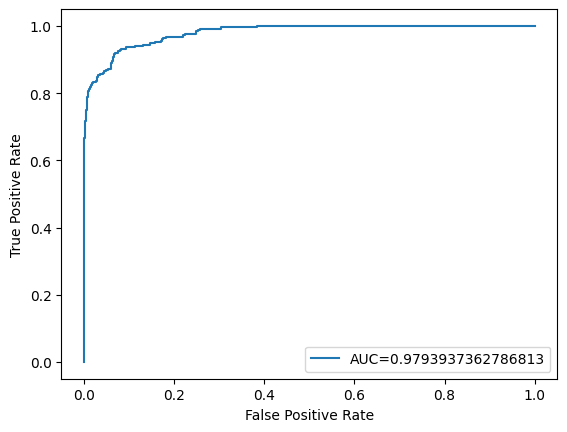

In [70]:
# ALWAYS reset X columns to the right order

cols_when_model_builds = best_xgboost.get_booster().feature_names
X_test=X_test[cols_when_model_builds]

y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_xgboost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = best_xgboost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [71]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_xgboost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.946 (0.014)


In [72]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_gradBoost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.947 (0.014)


[0.1 0.1 0.  ... 0.  0.3 0. ]


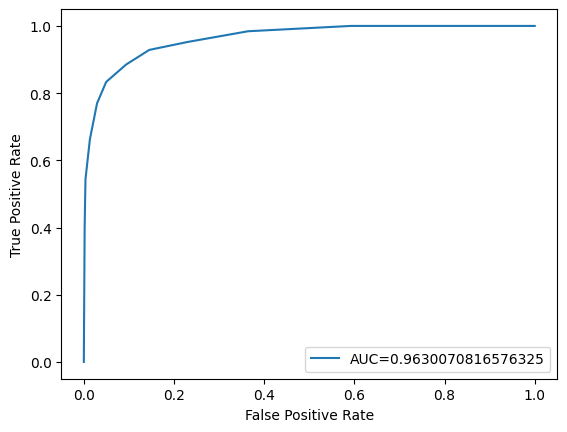

In [73]:
y_pred_proba = best_rF.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

[3.82075073e-03 4.41432276e-04 6.71296181e-03 ... 6.55295130e-04
 1.10691162e-01 5.58013109e-05]


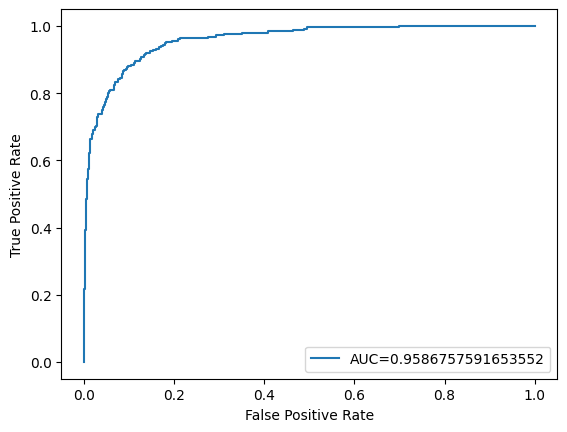

In [77]:
y_pred_proba = lrmodel.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [75]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_rF, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.906 (0.023)


In [76]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(lrmodel, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.937 (0.016)


In [79]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(knntest, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.865 (0.021)
